In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader, Dataset

from google.colab import drive



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)


def xavier_weight(*size):
    return torch.nn.init.xavier_uniform_(torch.empty(*size))

Mon Jan 18 08:11:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def get_convex_hull_txt(txt_file_dir):
    x = []
    y = []
    with open(txt_file_dir, 'r') as file:
        for line in file:
            data, target = line.split(" output ")
            data = data.split(' ')
            target = target.split(' ')[:-1]
            data = np.array(data).astype(np.float32) 
            target = np.array(target).astype(np.long)
            data = data.reshape(-1, 2)
            x.append(data)
            y.append(target)
        
    return x, y

class Dataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


drive.mount('/content/drive')
file_dir = '/content/drive/My Drive/'

# Data is from https://drive.google.com/drive/folders/0B2fg8yPGn2TCMzBtS0o4Q2RJaEU
train_set = Dataset(*get_convex_hull_txt(file_dir + 'convex_hull_50_train.txt'))
test_set =  Dataset(*get_convex_hull_txt(file_dir + 'convex_hull_50_test.txt'))

Mounted at /content/drive


In [3]:
def pad_and_pack(batch): 
    max_len = len(batch[0][1])
    for i in range(1, len(batch)):
        if max_len < len(batch[i][1]):
            max_len = len(batch[i][1])
    
    for i in range(len(batch)):
        if len(batch[i][1]) < max_len:
            label = batch[i][1]
            label = np.concatenate((label, np.zeros(max_len - len(label)).astype(np.int32)), axis=0)
            batch[i] = (batch[i][0], label)
        
    return torch.utils.data.dataloader.default_collate(batch)
    

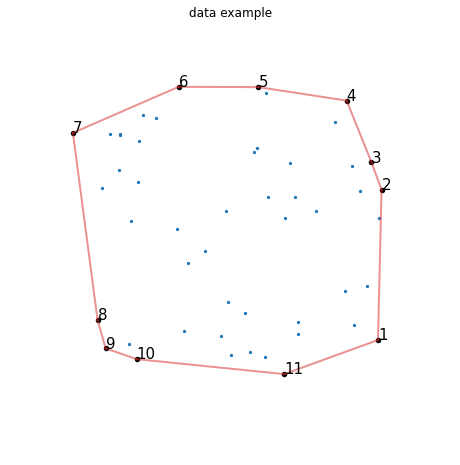

In [4]:
import matplotlib.pyplot as plt

data, label = train_set.__getitem__(10)
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=5)
for i in range(len(label) - 1):
    idx1, idx2 = label[i] - 1, label[i + 1] - 1
    plt.plot([data[idx1][0], data[idx2][0]], [data[idx1][1], data[idx2][1]], c='tab:red', linewidth=2, alpha=0.5)
    plt.scatter(data[idx1][0], data[idx1][1], s=20, c='#000000')
    plt.text(data[idx1][0], data[idx1][1], str(i + 1), fontsize=15)

plt.title('data example')
plt.xlim(-0.2, 1.2)
plt.ylim(-0.2, 1.2)
plt.axis('off')
plt.show()

In [32]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.rnns = nn.LSTM(input_size=embedding_size, hidden_size=embedding_size, num_layers=3, bias=True, batch_first=True, dropout=0, bidirectional=False)
        self.k_proj = nn.Parameter(xavier_weight(embedding_size, embedding_size), requires_grad=True)
        self.v_proj = nn.Parameter(xavier_weight(embedding_size, embedding_size), requires_grad=True)
        self.key_norm = 1 / np.sqrt(embedding_size)

    def forward(self, x):
        o, (h, c) = self.rnns(x)
        key = (o @ self.k_proj) * self.key_norm
        value = o @ self.v_proj
        return key, value, (h, c)


class Decoder(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.block = nn.ModuleList([ # Encoder.rnns.num_layers랑 같은 개수
            nn.LSTMCell(embedding_size, embedding_size, bias=True),
            nn.LSTMCell(embedding_size, embedding_size, bias=True),
            nn.LSTMCell(embedding_size, embedding_size, bias=True)
        ])
        self.xstart = nn.Parameter(xavier_weight(1, embedding_size), requires_grad=True)
        self.q_proj = nn.Linear(embedding_size, embedding_size, bias=False)
        self.l_proj = nn.Parameter(xavier_weight(embedding_size, 1), requires_grad=True)

        self.auxstart = nn.Parameter(xavier_weight(1, embedding_size), requires_grad=True)

    def forward(self, key, val, h, c, points, max_iter):
        nb, num_key, _ = key.size()
        batch_index = torch.arange(0, nb)
        prob_vec_cache = torch.zeros((nb, max_iter, num_key), dtype=torch.float).to(device)
        x = self.xstart.expand(nb, -1)
        mask_selected = torch.zeros((nb, num_key)).bool().to(device)

        aux = self.auxstart.expand(nb, -1)
        for s in range(max_iter):
            o, h, c = self.forward_rnn(x, aux, h, c)
            query = self.q_proj(o)
            atten_input = torch.tanh(query.unsqueeze(dim=1).expand_as(key) + key)
            atten = (atten_input @ self.l_proj).squeeze(dim=2) #[nb, num_key]
            atten = atten.masked_fill(mask_selected==True, -np.inf)
            atten = torch.softmax(atten, dim=1)
            prob_vec_cache[:, s, :] = atten
            aux = (atten_input.squeeze(-1) * atten_input).sum(dim=1)
            selected = torch.argmax(atten, dim=1)
            x = points[batch_index, selected, :]
            if s > 0 :
                mask_selected[batch_index, selected] = True

        return prob_vec_cache

    
    def forward_rnn(self, x, aux, h_prev, c_prev):
        h_curr = []
        c_curr = []
        h = x
        for i, block in enumerate(self.block):
            h, c = block(h + aux, (h_prev[i], c_prev[i]))
            h_curr.append(h)
            c_curr.append(c)
        return h, h_curr, c_curr

        

class ConvexHullSolver(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.embedding = nn.Parameter(xavier_weight(2, embedding_size), requires_grad=True)
        self.drop = nn.Dropout(0.5)
        self.enc = Encoder(embedding_size)
        self.dec = Decoder(embedding_size)

    def forward(self, x, max_iter):
        x = x @ self.embedding
        x = self.drop(x)
        key, val, (h_enc, c_enc) = self.enc(x)
        prob_vec = self.dec(key, val, h_enc, c_enc, x, max_iter)
        return prob_vec



In [33]:
import torch.optim as optim

n_emb = 256
model = ConvexHullSolver(n_emb).to(device)
solver = optim.Adam(model.parameters(), 1e-3)
loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True, collate_fn=pad_and_pack)
# criterion = nn.CrossEntropyLoss()

def cross_entropy_for_softmax(prob_vec, tar_idx):
    tar_idx = tar_idx.unsqueeze(-1)
    one_hot = torch.zeros_like(prob_vec).scatter_(-1, tar_idx, 1)
    log_prob = torch.log(prob_vec + 1e-3)
    cross_entropy = -log_prob * one_hot
    cross_entropy = cross_entropy.sum(dim=2)
    return cross_entropy


In [36]:
num_epochs = 5
for epoch in range(num_epochs):
    for (x, y) in loader:
        solver.zero_grad()
        x = x.to(device)
        y = y.long().to(device)
        prob = model(x, y.size(1))
        prob = torch.cat([torch.zeros((y.size(0), y.size(1), 1), dtype=torch.float).to(device), prob], dim=2)

        loss = F.cross_entropy(prob.transpose(1, 2).contiguous(), y, reduction='mean')
        # loss = cross_entropy_for_softmax(prob, y).mean()


        loss.backward()
        solver.step()
    print(loss.item())



3.850581169128418
3.844451904296875
3.8265786170959473
3.828439235687256
3.828747510910034


In [37]:
def eval_show(x, max_iter=20):

    model.eval()
    logits = model(x, max_iter)
    label = torch.argmax(logits, dim=2)
    model.train()
    plt.figure(figsize=(8, 8))
    x = x.squeeze(0).detach().cpu()
    label = label.squeeze(0).detach().cpu()
    plt.scatter(x[:, 0], x[:, 1], s=5)
    for i in range(max_iter - 1):
        idx1, idx2 = label[i], label[i + 1]
        plt.plot([x[idx1][0], x[idx2][0]], [x[idx1][1], x[idx2][1]], c='tab:red', linewidth=2, alpha=0.5)
        plt.scatter(x[idx1][0], x[idx1][1], s=20, c='#000000')
        plt.text(x[idx1][0], x[idx1][1], str(i + 1), fontsize=15)
        if idx2 == label[0]:
            break


    plt.xlim(-0.2, 1.2)
    plt.ylim(-0.2, 1.2)
    plt.axis('off')
    plt.show()


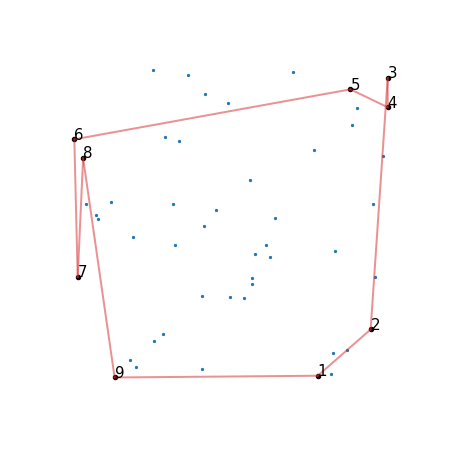

In [38]:
data_index = 0
x, _ = test_set.__getitem__(data_index)
x = torch.from_numpy(x).unsqueeze(0).to(device)
eval_show(x, 20)

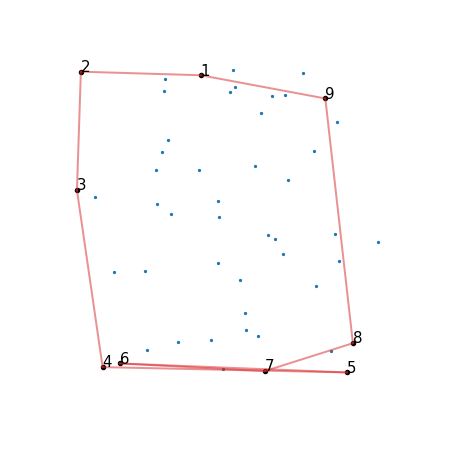

In [39]:
data_index = 50
x, _ = test_set.__getitem__(data_index)
x = torch.from_numpy(x).unsqueeze(0).to(device)

eval_show(x, 20)

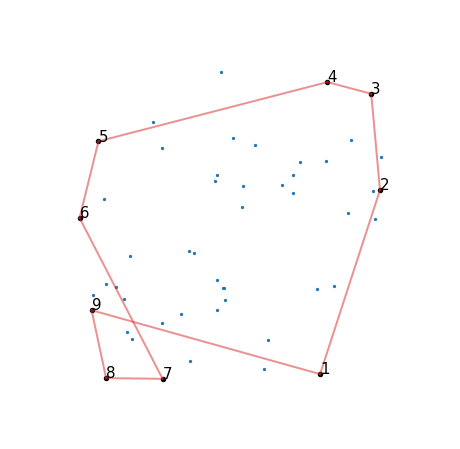

In [40]:
data_index = 500
x, _ = test_set.__getitem__(data_index)
x = torch.from_numpy(x).unsqueeze(0).to(device)

eval_show(x, 20)